# INSTRUCTIONS

#### Part 1: Computing the optimal speed from the optimal racing line
- Part 1 of this notebook takes the optimal racing line, which can be generated with Race-Line-Calculation.ipynb ([GitHub](https://github.com/cdthompson/deepracer-k1999-race-lines)), and generates the optimal speed for each point on the racing line
- Input: .py file with 2D array containing optimal racing line: 2 columns (x,y)
- Output: .py file with 2D array: 4 columns (x,y,speed,expected time). This array can be inserted into the reward function
- Note: The last point of the racing line is deleted because it is the same point as the first one

#### Part 2: Computing the Action Space
- Part 2 of this notebook takes the optimal racing line and speed, and uses K-Means with Gaussian Noise infused data, to calculate the action space

In [14]:
from networkx import minimum_spanning_tree
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math
from matplotlib import pyplot as plt
import seaborn as sns
# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [40]:
# Path of the optimal racing line (.npy file)
fpath = 'racelines/2022_may_open_ccw-5000-8-2024-09-05-204654.npy'

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "2022_may_open_ccw"

racing_track = np.load(fpath)

# Convert np array c to list and remove last point because it is the same point as the first one
racing_track = racing_track.tolist()[:-1]

In [41]:
racing_track

[[5.047718552227854, 0.6586279875615562],
 [5.047705368460672, 0.8417713769544908],
 [5.047693130022095, 1.0093705025397193],
 [5.047051577986936, 1.1940916936555364],
 [5.04291648304978, 1.471897987447122],
 [5.031906597560246, 1.7649279029395055],
 [5.01149011247314, 2.0570051158263376],
 [4.979509881923503, 2.344482187843883],
 [4.934089095332341, 2.6256407035428877],
 [4.873630398053016, 2.89904577826435],
 [4.796781694168223, 3.16329929897651],
 [4.702376651974088, 3.4169637383966993],
 [4.5893614042294875, 3.6584817169970254],
 [4.456805115341325, 3.8861297462291855],
 [4.303843105040474, 4.097893935689013],
 [4.1291311124652035, 4.290778262284517],
 [3.9353045919867164, 4.465080942585372],
 [3.724550991965563, 4.6211716347134],
 [3.4987271397553825, 4.759441523924446],
 [3.2594703385942543, 4.880317424361419],
 [3.0082708465082844, 4.984286939796949],
 [2.7465408903731996, 5.071960962970621],
 [2.475641078553933, 5.144106809408278],
 [2.1968987356345675, 5.201688489195522],
 [1.

# Helper functions for Part 1 and Part 2

In [42]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2

    if abs(a) < 1e-7:  # Check if 'a' is very close to zero (indicating near-collinearity)
        print('! warn: nearing colinear points')
        # return 1e-7  # early exit
    
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):
    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],track[indexes[1]], track[indexes[2]]]
        r = circle_radius(coords)
        if r == 1e-7:
            r = radius[i-1] + 1e-7
        radius.append(r)
    

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

# Part 1: Calculate optimal speed

- Change ```LOOK_AHEAD_POINTS``` to influence how many points the algorithm looks ahead (the higher, the sooner the car will start to break)
- Change ```MIN_SPEED``` and ```MAX_SPEED``` to fit the track and model !

In [43]:
LOOK_AHEAD_POINTS = 4
MIN_SPEED = 1.55
MAX_SPEED = 4.0

In [44]:
# Calculate optimal speed
velocity = optimal_velocity(track=racing_track,
                            min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

! warn: nearing colinear points
! warn: nearing colinear points
! warn: nearing colinear points
! warn: nearing colinear points
! warn: nearing colinear points
Constant multiple for optimal speed: 1.549137678291449


! warn: nearing colinear points
! warn: nearing colinear points
! warn: nearing colinear points
! warn: nearing colinear points
! warn: nearing colinear points
Constant multiple for optimal speed: 1.549137678291449


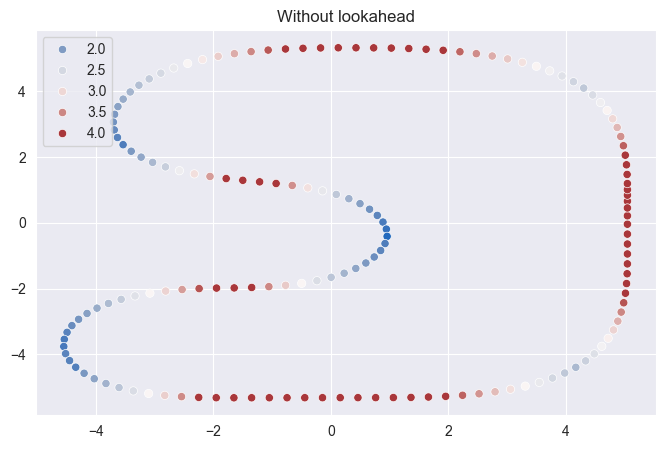

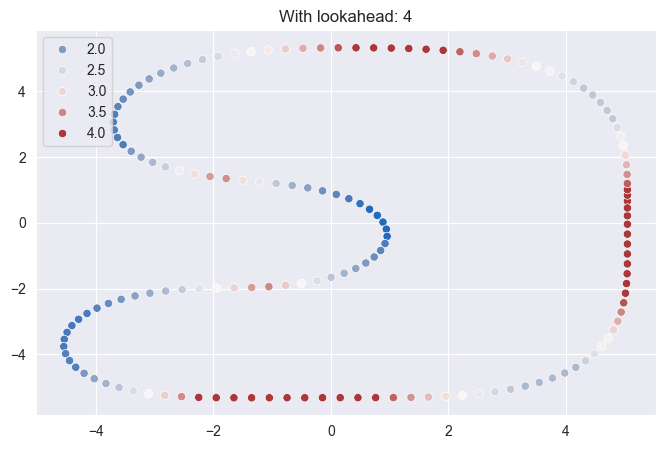

In [45]:
x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")

#### Calculate distance and optimal time between each racing point


In [46]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)

time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 16.121598527017508 s


## Append everything together and save to .txt file


In [47]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()
# Write to txt file
with open(f'optimals/optimals_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

# Part 2: Calculate Optimal Action Space


In [25]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)  # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]], racing_track[indexes[1]], racing_track[indexes[2]]]
    r = circle_radius(coords)
    if r == 1e-7:
        r = radius[-1] + 1e-7
    radius.append(r)

! warning, nearing colinear points
! warning, nearing colinear points
! warning, nearing colinear points
! warning, nearing colinear points
! warning, nearing colinear points
! warning, nearing colinear points


In [26]:
# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]], racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

In [27]:
# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if not left_curve[i]:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

In [28]:
# Calculate steering with + and -
dist_wheels_front_back = 0.165  # meters
steering = []
for i in range(len(racing_track)):
    try:
        steer = math.degrees(math.asin(dist_wheels_front_back / radius_direction[i]))
    except:
        steer = steering[-1] + 0.0001
    steering.append(steer)

In [29]:
# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity": velocity, "steering": steering})
min(radius)

1.0134764374463476

#### Calculate Action Space with K-Means and Resampling each point with normal distribution


<Axes: ylabel='Density'>

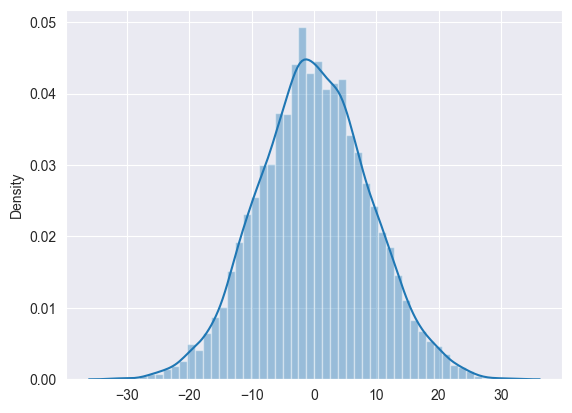

In [30]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
steering_sd
sns.distplot(np.random.normal(0, steering_sd, 10000))

<Axes: ylabel='Density'>

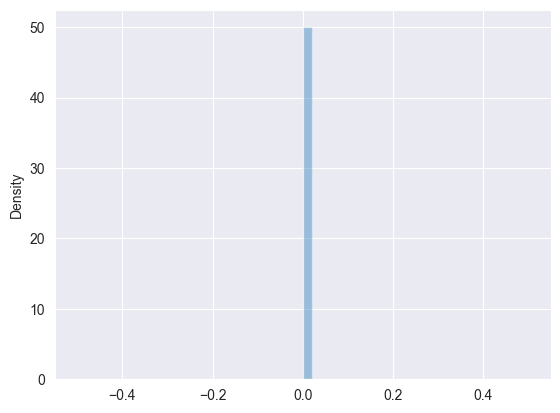

In [31]:
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
sns.distplot(np.random.normal(0, velocity_sd, 10000))


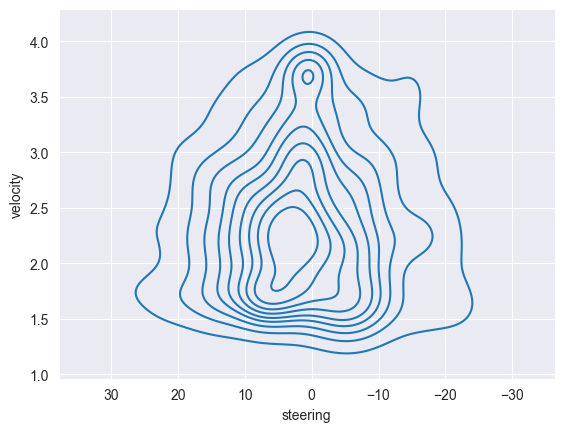

In [32]:
all_actions_norm = all_actions.copy()
all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm, s_norm]), columns=["velocity", "steering"])
    all_actions_norm = pd.concat([all_actions_norm, vs_norm], axis=0, ignore_index=True)

# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]

# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions, all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm, add_initial_actions], axis=0, ignore_index=True)

# Display actions shape
all_actions_norm.shape
all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True)  # sample bc less compute time
ax = sns.kdeplot(x=all_actions_norm_less["steering"], y=all_actions_norm_less["velocity"])
ax.invert_xaxis()
X = all_actions_norm

In [33]:
# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X),
                        columns=["velocity", "steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 21 - 2
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

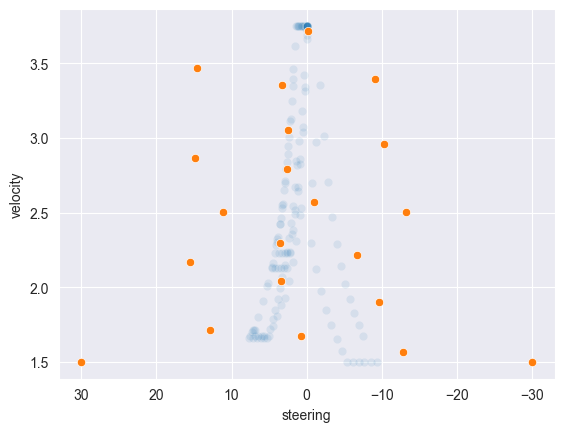

In [34]:
# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_),
                           columns=["velocity", "steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity": [MIN_SPEED, MIN_SPEED], "steering": [30, -30]})
X_centroids = pd.concat([X_centroids, manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

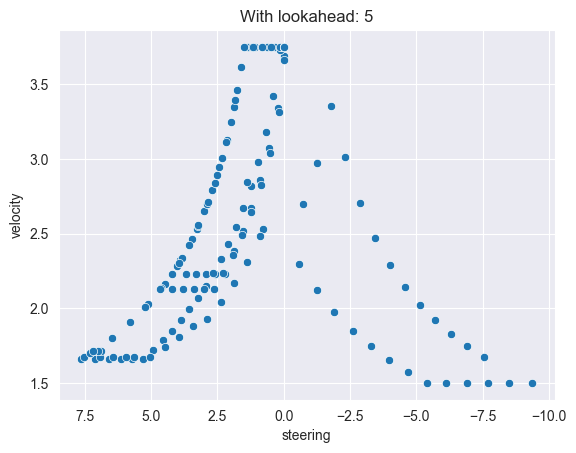

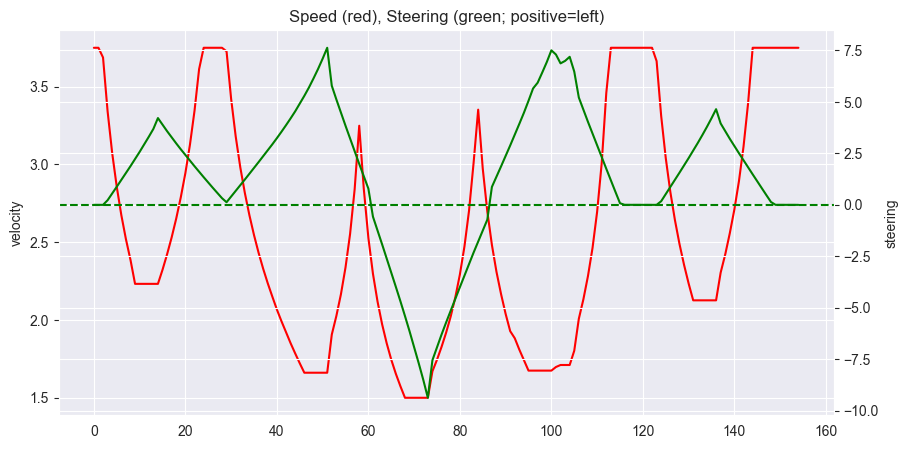

In [35]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")
# Visualize all actions
plt.figure(figsize=(10, 5))
sns.lineplot(data=all_actions["velocity"], color="r")
ax2 = plt.twinx()
sns.lineplot(data=all_actions["steering"], color="g", ax=ax2)
plt.axhline(0, ls='--', color="g")
a = plt.title("Speed (red), Steering (green; positive=left)")

In [36]:
# Output JSON format
action_space_for_json = action_space_e[["steering", "velocity"]].copy()

action_space_for_json = action_space_for_json.round(4)
action_space_for_json.columns = ["steering_angle", "speed"]
action_space_for_json["index"] = action_space_for_json.index
json_text = action_space_for_json.to_json(orient="records", lines=False)

action_space_for_json
with open(f'optimals/AS21_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write(json_text)

#### Calculate Action Space with K-Means and Resampling each point with normal distribution

<Axes: ylabel='Density'>

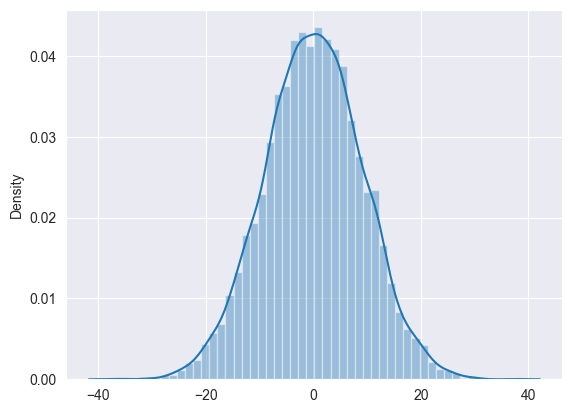

In [39]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
steering_sd
sns.distplot(np.random.normal(0,steering_sd,10000))

<Axes: ylabel='Density'>

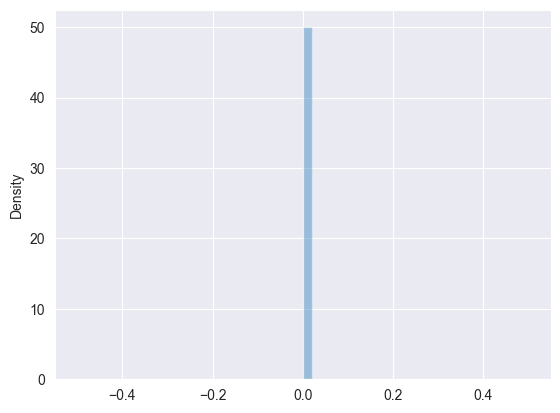

In [40]:
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
sns.distplot(np.random.normal(0,velocity_sd,10000))

In [41]:
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)
    
# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]
    
# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

(146502, 2)

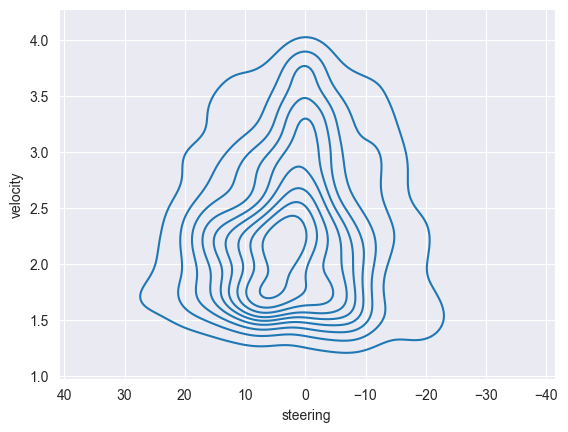

In [42]:
all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True) # sample bc less compute time
ax = sns.kdeplot(x=all_actions_norm_less["steering"],y=all_actions_norm_less["velocity"])
ax.invert_xaxis()

In [43]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), 
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 21-2
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_), 
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED,MIN_SPEED],"steering":[30,-30]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

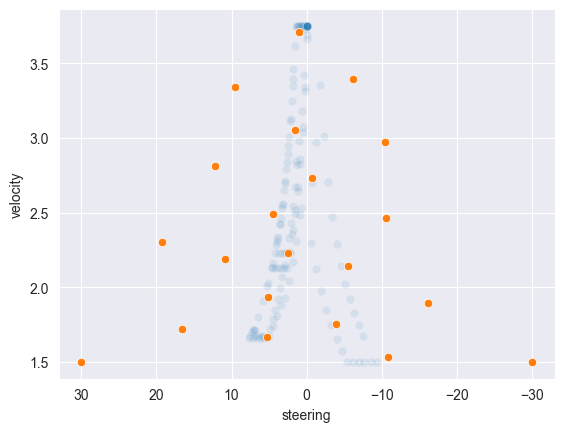

In [44]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

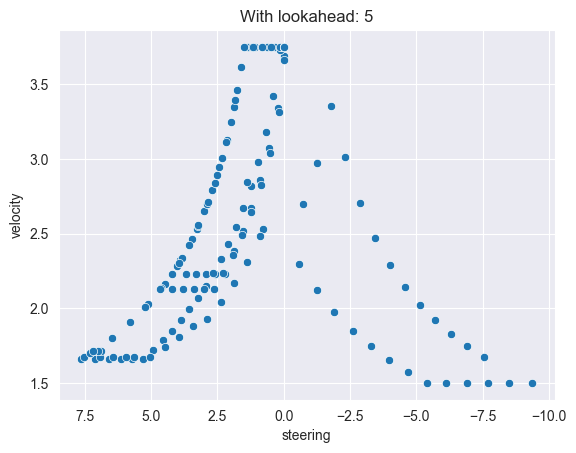

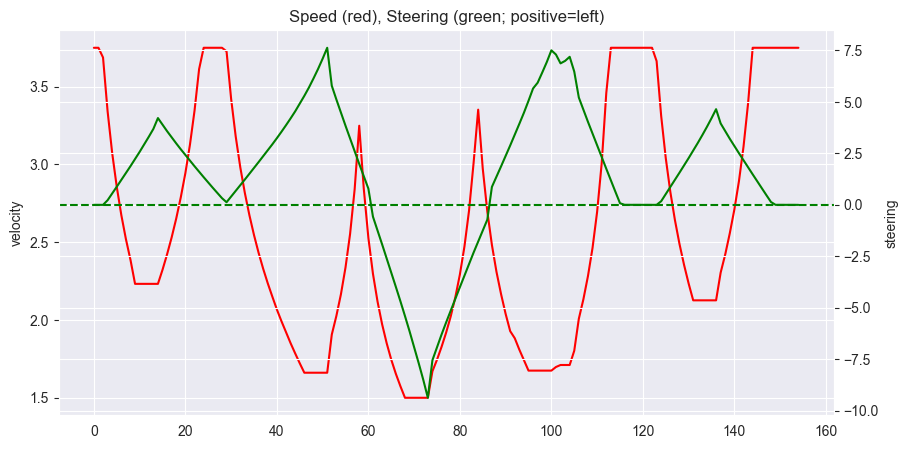

In [47]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")
# Visualize all actions
plt.figure(figsize=(10, 5))
sns.lineplot(data=all_actions["velocity"], color="r")
ax2 = plt.twinx()
sns.lineplot(data=all_actions["steering"], color="g", ax=ax2)
plt.axhline(0, ls='--', color="g")
a = plt.title("Speed (red), Steering (green; positive=left)")

*Note: Action space can be different every time it is computed because of randome resampling with gaussian noise and also because of the random seed with K-Means. Therefore, try out multiple iterations until you are happy with the result*

#### Output as JSON format

In [45]:
# Output JSON format
action_space_for_json = action_space_e[["steering","velocity"]].copy()
    
action_space_for_json = action_space_for_json.round(4)
action_space_for_json.columns = ["steering_angle","speed"]
action_space_for_json["index"] = action_space_for_json.index
json_text = action_space_for_json.to_json(orient="records", lines=False)

action_space_for_json

,steering_angle,speed,index
0,-3.9523,1.7525,0
1,9.5311,3.3385,1
2,2.4988,2.2281,2
3,12.2138,2.8094,3
4,16.6005,1.7222,4
5,-10.4275,2.9721,5
6,1.0072,3.7112,6
7,-16.1074,1.8950,7
8,19.2052,2.3048,8
9,1.6124,3.0524,9


In [ ]:
with open(f'optimals/AS21_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write(json_text)